<a href="https://colab.research.google.com/github/vohoaidanh/AIGCDetectBenchmark/blob/main/colab/intrinsic_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to set the runtime to GPU: Runtime -> Change runtime type -> T4 GPU

You can upload your own images, then change the relevant code cells to load it and send it through the model.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# install the intrinsic decomposition repo from github
!pip install https://github.com/compphoto/Intrinsic/archive/main.zip

     \ 29.2 MB 27.1 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/MiDaS (to revision master) to /tmp/pip-install-4v3_3ofv/altered-midas_20de29836a144755a030b74b9b42d00c
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/MiDaS /tmp/pip-install-4v3_3ofv/altered-midas_20de29836a144755a030b74b9b42d00c
  Resolved https://github.com/CCareaga/MiDaS to commit 043f3b8d9f6d2f7e740a8ac45e0745c0b5e2fd03
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/chrislib (to revision main) to /tmp/pip-install-4v3_3ofv/chrislib_e417dd5b603b4558899cbc6df5c454c7
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/chrislib /tmp/pip-install-4v3_3ofv/chrislib_e417dd5b603b4558899cbc6df5c454c7
  Resolved https://github.com/CCareaga/chrislib to commit 6834448930593ec6f7403f411bd42beaf3afb27b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2

In [4]:
import torch

# import some helper functions from chrislib (will be installed by the intrinsic repo)
from chrislib.general import show, view, uninvert
from chrislib.data_util import load_image

# import model loading and running the pipeline
from intrinsic.pipeline import run_pipeline
from intrinsic.model_util import load_models

In [5]:
# download the pretrained weights and return the model (may take a bit to download weights)
intrinsic_model = load_models('paper_weights')

Downloading: "https://github.com/compphoto/Intrinsic/releases/download/v1.0/final_weights.pt" to /root/.cache/torch/hub/checkpoints/final_weights.pt
100%|██████████| 485M/485M [00:10<00:00, 50.3MB/s]
Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth
100%|██████████| 340M/340M [00:06<00:00, 53.8MB/s]
/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(...,

In [6]:
# load an example image from the github repo
torch.hub.download_url_to_file('https://raw.githubusercontent.com/compphoto/Intrinsic/main/figures/avocado.png', 'avo.png')

100%|██████████| 2.85M/2.85M [00:00<00:00, 13.8MB/s]


In [7]:
# load the image to run through the pipeline
img = load_image('/content/avo.png')

In [8]:
# run the image through the pipeline (use R0 resizing dicussed in the paper)
result = run_pipeline(
    intrinsic_model,
    img,
    resize_conf=0.0,
    maintain_size=True,
    linear=False,
    device='cuda'
)

In [9]:
# convert the inverse shading to regular shading for visualization
shd = uninvert(result['inv_shading'])
alb = result['albedo']

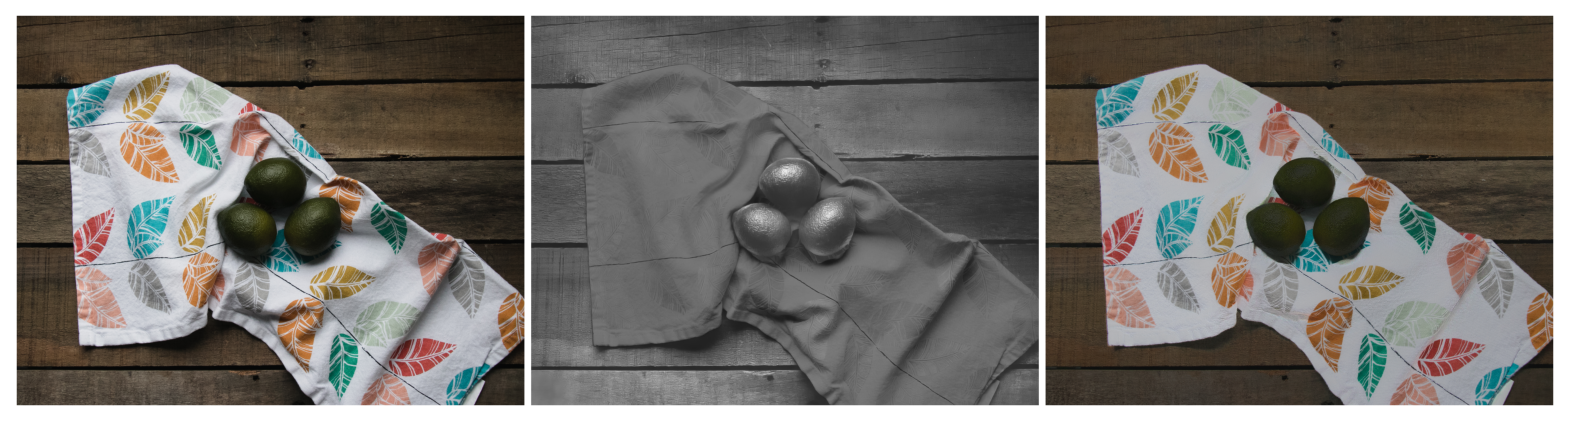

In [10]:
# show the result (gamma corrects the linear intrinsic components and scales to [0-1])
show([img, view(shd), view(alb)], size=(20, 7))

In [11]:
import os

def get_image_list(data_path):
  # Get all images in dataset (return a list of path of each image)
  items = os.listdir(data_path) # Each item contains 40 images
  image_list = []
  for item in items:
    f = os.path.join(data_path, item)
    imgs = os.listdir(f)
    imgs = [os.path.join(f,imgs) for i in imgs]
    image_list.extend(imgs)
  return image_list


In [12]:
!cp /content/drive/MyDrive/DATASETS/DiffusionForensics/imagenet/real.tar.gz -d /content

In [16]:
!gunzip /content/real.tar.gz

In [ ]:
!tar -xvf /content/real.tar

In [22]:
items = os.listdir('/content/real') # Each item contains 40 images

In [28]:
f'data\{0}'.format(r'n001')

'data\\0'

In [23]:
items[:10]

['n02879718',
 'n03100240',
 'n03085013',
 'n02504013',
 'n04596742',
 'n02110063',
 'n13054560',
 'n01828970',
 'n04141975',
 'n04562935']

# Run process all images in the list

In [ ]:
#data_path = ''
#images = get_image_list(data_path)

print('Total: {0} images'.format(len(images)))

for image in images:
    result = run_pipeline(
      intrinsic_model,
      img,
      resize_conf=0.0,
      maintain_size=True,
      linear=False,
      device='cuda'
    )

    albedo = results['albedo']
    inv_shd = results['inv_shading']

    # compute shading from inverse shading
    shading = uninvert(inv_shd)